In [2]:
# Environment

import random

# Splits the cards of the game
def createGame():
  face_cards = ["A", "J", "Q", "K"]
  all_cards = 4 * face_cards
  random.shuffle(all_cards)

  cards_player1 = {"A": 0, "J": 0, "Q": 0, "K": 0}
  cards_player2 = {"A": 0, "J": 0, "Q": 0, "K": 0}

  for i, card in enumerate(all_cards):
    if i < 8:
      cards_player1[card] += 1
    else:
      cards_player2[card] += 1

  deck = []

  return cards_player1, cards_player2, deck

# get all cards from deck
def get_all_deck_cards(cards_player, deck):
  for card in deck:
    cards_player[card] += 1
  deck.clear()

In [3]:
# Actions (Agent)

# Validation of number of cards of the same type (A, J, Q, K)
def validation_move(type_card, n, cards_player):
  # the oponnet card must be the complement of my own
  return cards_player[type_card] + n == 4

# Action of doubting
def doubt(type_card, n, deck, cards_player1, cards_player2):
  # considering that we “follow” player 1
  get_all_cards = False

  # if the opponnent was not honest
  for deck_card in range(n):
    if deck[-deck_card - 1] != type_card:
      break
  else:
    get_all_cards = True

  if get_all_cards:
    get_all_deck_cards(cards_player2, deck)
  else:
    get_all_deck_cards(cards_player1, deck)

# Auxilar function for bluffing
def updates_weights(main_card):
    face_cards = ['A', 'J', 'Q', 'K']
    index_main_card = face_cards.index(main_card)

    weights = {}
    for i, card in enumerate(face_cards):
        weights[card] = (index_main_card + i) % 4 + 1

    return weights

# Bluff function
def bluff(type_card, n, cards_player, deck):
  # updating the probability with each move
  face_cards = ['A', 'J', 'Q', 'K']
  weights = updates_weights(type_card)
  for i in range(n):
    total_weight = 0
    for card in face_cards:
      total_weight += cards_player[card] * weights[card]

    # calculating the probability of choosing each type of card
    pA = ((cards_player['A'] * weights['A']) / total_weight)
    pJ = ((cards_player['J'] * weights['J']) / total_weight)
    pQ = ((cards_player['Q'] * weights['Q']) / total_weight)
    pK = ((cards_player['K'] * weights['K']) / total_weight)

    # Throwing the card with higher probability
    probabilities = {'A': pA, 'J': pJ, 'Q': pQ, 'K': pK}
    highest_probable_card = max(probabilities, key=probabilities.get)
    cards_player[highest_probable_card] -= 1
    deck.append(highest_probable_card)

# Throws the card honestly
def honest_move(type_card, n, cards_player, deck):
  cards_player[type_card] -= n
  for i in range(n):
    deck.append(type_card)

In [4]:
# Main function of decision (zero-order)
def decide_move_zero_order(type_card, n, deck, cards_player1, cards_player2, move_player2, n_player2, type_card_player2):
  n_max = cards_player1[type_card]

  # calculating probabilities
  Pdoubt = 1 - (cards_player2[type_card] / sum(cards_player2.values())) if cards_player2[type_card] > 0 else 1
  if sum(cards_player1.values()) < 4:
    Pbluff = lambda n: (n - cards_player1[type_card]) / n if n > cards_player1[type_card] else 0.5  # Increases the probability of bluffing if the player has few cards
  else:
    Pbluff = lambda n: (n - cards_player1[type_card]) / n if n > cards_player1[type_card] else 0


  # expected values
  Vhonest = Pbluff(n) * (-len(deck)) + (1 - Pdoubt) * 0
  Vbluff = max(Pdoubt * (-len(deck)) + Pbluff(n) * (-len(deck)) + (1 - Pdoubt - Pbluff(n)) * n for n in range(1, n_max + 2)) # Changed '-deck' to '-len(deck)'

  # checking whether doubting is advantageous
  if move_player2 == 'H' or move_player2 == 'B':
    valid_move = validation_move(type_card, n_player2, cards_player2)
    Vdoubt = -len(deck) if valid_move else +len(deck)
  else:
    Vdoubt = float('-inf') # if the player started the round

  # final decision
  if Vhonest >= Vbluff and Vhonest >= Vdoubt:
    honest_move(type_card, n_max, cards_player1, deck)
    move = 'H'
    # print("The player made an honest move")
  elif Vbluff >= Vhonest and Vbluff >= Vdoubt:
    bluff(type_card, n_max, cards_player1, deck)
    move = 'B'
    # print("The player made a bluff")
  else:
    doubt(type_card_player2, n_player2, deck, cards_player2, cards_player1)
    move = 'D'
    # print("The player doubt the previous move of the adversary")
    print("The other player doubt your last move!")

  return move, n_max, type_card

# Function that tries to predict the other player movement
def predict_opponent_behavior(opponent_cards_estimation, deck, last_move, n_played, own_cards, n):
  # initialization of the probabilities
  Phonest = 0.45
  Pbluff = 0.45
  Pdoubt = 0.1

  # adjustments based the number of each of cards
  for card, count in opponent_cards_estimation.items():
    if count >= 3:
      Pbluff += 0.2
    elif count <= 1:
      Phonest += 0.2

  # adjustments based on the last movement
  if last_move in ['H', 'B']:
    opponent_hand_count = sum(opponent_cards_estimation.values())
    if opponent_hand_count <= 3 and n_played >= 2:
      Pbluff += 0.2
    else:
      Phonest += 0.1
  else:
    Phonest += 0.2

  # analyzing if the player is going to doubt
  own_hand_count = sum(own_cards.values())
  if own_hand_count <= 3 and n >= 2:
    Pdoubt += 0.5

  # normalization of probabilities
  total = Phonest + Pbluff + Pdoubt
  Phonest /= total
  Pbluff /= total
  Pdoubt /= total

  return Phonest, Pbluff, Pdoubt

# Main function of decision (first-order)
def decide_move_first_order(type_card, n, deck, cards_player1, cards_player2, move_player2, n_player2, type_card_player2, n_played):
  n_max = cards_player1[type_card]

  # predict the opponent's behavior based on their estimated cards and the game state
  Phonest, Pbluff, Pdoubt = predict_opponent_behavior(cards_player2, deck, move_player2, n_played, cards_player1, n)

  # calculate the expected values for each movement paginated table
  Vhonest = (1 + Pdoubt) * n - (1 - Pdoubt) * len(deck)
  Vbluff = max(Pdoubt * (-len(deck)) + Pbluff * (-len(deck)) + (1 - Pdoubt - Pbluff) * n for n in range(1, cards_player1[type_card] + 2))

  # check if doubting is advantageous
  if move_player2 == 'H' or move_player2 == 'B':
    opponent_hand_count = sum(cards_player2.values())
    if opponent_hand_count <= 3 and n_played >= 2:
      Vdoubt = Pdoubt
    else:
      Vdoubt = -len(deck)
  else:
    # if the player started the round
    Vdoubt = float('-inf')

  if Vhonest >= Vbluff and Vhonest >= Vdoubt:
    honest_move(type_card, n, cards_player1, deck)
    move = 'H'
  elif Vbluff >= Vhonest and Vbluff >= Vdoubt:
    bluff(type_card, n, cards_player1, deck)
    move = 'B'
  else:
    doubt(type_card_player2, n_player2, deck, cards_player2, cards_player1)
    move = 'D'

  return move, n, type_card

In [5]:
# Main (agent vs. agent)

# variables to plot
player1_cards_history = []
player2_cards_history = []
deck_cards_history = []
moves_history = []

def agent_agent(order_agent0, order_agent1):
  face_cards = ['A', 'J', 'Q', 'K']
  cards_player1, cards_player2, deck = createGame()
  round = 0

  # Initialization to avoid errors in the first round
  move_player2 = None
  n_max2 = 0
  type_card_player2 = 'A'

  # Track number of cards played
  n_played_player1 = 0
  n_played_player2 = 0

  print("============== The game has strated! ==============")

  while True:
    # round settings
    type_card = face_cards[round % 4]
    n_player1 = cards_player1[type_card]
    n_player2 = cards_player2[type_card]

    #Exhibiting what is happening
    print("Round", round + 1)
    print("Type of the card:", type_card)
    print("Player 1:", cards_player1)
    print("Player 2:", cards_player2)
    print("Deck:", deck)

    # real game
    if order_agent0 == 0:
      move_player1, n_max1, type_card_player1 = decide_move_zero_order(type_card, n_player1, deck, cards_player1, cards_player2, move_player2, n_max2, type_card_player2)
    else:
      move_player1, n_max1, type_card_player1 = decide_move_first_order(type_card, n_player1, deck, cards_player1, cards_player2, move_player2, n_max2, type_card_player2, n_played_player2)
    n_played_player1 = n_max1
    if all(value == 0 for value in cards_player1.values()):
      print("============== Player 1 won! ==============")
      break
    print(cards_player1)
    print(cards_player2)
    print(deck)
    if order_agent1 == 0:
      move_player2, n_max2, type_card_player2 = decide_move_zero_order(type_card, n_player2, deck, cards_player2, cards_player1, move_player1, n_max1, type_card_player1)
    else:
      move_player2, n_max2, type_card_player2 = decide_move_first_order(type_card, n_player2, deck, cards_player2, cards_player1, move_player1, n_max1, type_card_player1, n_played_player1)
    n_played_player2 = n_max2
    if all(value == 0 for value in cards_player2.values()):
      print("============== Player 2 won! ==============")
      break
    print(cards_player1)
    print(cards_player2)
    print(deck)

    print("=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*")
    player1_cards_history.append(sum(cards_player1.values()))
    player2_cards_history.append(sum(cards_player2.values()))
    deck_cards_history.append(len(deck))
    moves_history.append(move_player1)
    moves_history.append(move_player2)
    if round >= 200:
      print("Maximum number of rounds reached")
      break
    round += 1

In [6]:
# Main (agent vs. human)

# variables to plot
player1_cards_history = []
player2_cards_history = []
deck_cards_history = []
moves_history = []

def agent_human(order_agent):
    face_cards = ['A', 'J', 'Q', 'K']
    cards_player1, cards_player2, deck = createGame()
    round = 0

    print("============== The game has started! ==============")

    while True:
        # round settings
        type_card = face_cards[round % 4]
        n_player2 = cards_player2[type_card]
        type_card_player1 = 'A'
        type_card_player2 = 'A'

        print("Round", round + 1)
        print("Type of the card:", type_card)
        print("Your cards:", cards_player1)
        print("Number of opponent's cards:", sum(cards_player2.values()))
        print("Number of cards on deck:", len(deck))

        # Real game
        print("1. Play the cards")
        print("2. Doubt")
        print("0. Exit")
        # Loop to guarantee a valid move
        while True:
            move_player1 = input("Select the number of the move you want to make next: (1 | 2| O): ")
            if move_player1 == '2' and len(deck) == 0:
                print("You can't doubt if the deck is empty. Choose again")
            elif move_player1 == '1' or move_player1 == '2' or move_player1 == '0':
                break  # Exit the loop if the input is valid
            else:
                print("Invalid number, please select 1 or 2")

        if move_player1 == '1':
            move_player1 = 'H'
            n_max1 = -1
            while n_max1 < 0:
                n_max1_str = input("How many cards you want to throw? ")
                if not n_max1_str.isdigit():
                    print("Invalid input. Please enter a number.")
                    continue
                n_max1 = int(n_max1_str) # Convert to int if it's a number
                if n_max1 < 0:
                    print("Negative numbers are not allowed. Try again")
                elif n_max1 >= 16:
                    print("Be sure to enter a number within the valid range. Try again")

            count = 0
            while count < n_max1:
                type_actual_card = input("Write the type of card you want to throw (A | J | Q | K): ")
                type_actual_card = type_actual_card.upper()
                if type_actual_card not in face_cards:
                    print("Invalid type of card, please select A, J, Q or K")
                elif cards_player1[type_actual_card] <= 0:
                    print("The type of card you selected doesn't have enough cards. Try again")
                else:
                    cards_player1[type_actual_card] -= 1
                    deck.append(type_actual_card)
                    print("Updated hand:", cards_player1)
                    if type_actual_card != type_card:
                        move_player1 = 'B'
                        # print("Bluffed!")
                    count += 1

        elif move_player1 == '2':
            move_player1 = 'D'
            n_player2 = 0
            doubt(type_card_player2, n_player2, deck, cards_player2, cards_player1)
        else:
            print("Goodbye!")
            return

        # Track number of cards played
        n_played_player = n_max1

        winner = "None"
        if all(value == 0 for value in cards_player1.values()):
            winner = "Player 1"
        if order_agent == 0:
            move_player2, n_max2, type_card_player2 = decide_move_zero_order(type_card, n_player2, deck, cards_player2, cards_player1, move_player1, n_max1, type_card)
        else:
            move_player2, n_max2, type_card_player2 = decide_move_first_order(type_card, n_player2, deck, cards_player2, cards_player1, move_player1, n_max1, type_card, n_played_player)
        if all(value == 0 for value in cards_player2.values()) and winner == "None":
            print("============== Player 2 won! ==============")
            break
        elif all(value == 0 for value in cards_player1.values()):
            print("================= You won! =================")
            break

        print("=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*")

        # Collect data for plotting
        player1_cards_history.append(sum(cards_player1.values()))
        player2_cards_history.append(sum(cards_player2.values()))
        deck_cards_history.append(len(deck))
        moves_history.append(move_player1)
        print(player1_cards_history)

        if round > 50:
            print("Maximum number of rounds reached")
            break
        round += 1

In [79]:
history_player1 = [[6, 3], [8, 6, 4, 1], [5, 2], [6, 3, 1]]
history_player2 = [[4, 13], [5, 3, 2, 15], [7, 14], [6, 13, 11]]

In [123]:
# Game manager

def main():
  print("1. Analyze two agents against each other")
  print("2. Play against a agent")
  print("0. Exit")
  # Loop to ensure the player selects a valid option
  while True:
    choice = input("Select an option: (1 | 2| O): ")
    if choice == '1':
      order_agent0 = input("Select the order of the first agent (0 | 1): ")
      order_agent1 = input("Select the order of the second agent (0 | 1): ")
      if (order_agent0 == '0' or order_agent0 == '1') and (order_agent1 == '0' or order_agent1 == '1'):
        agent_agent(order_agent0, order_agent1)
        break
      else:
        print("Invalid number, please select 0 or 1")
    if choice == '2':
      order_agent = input("Select the order of the agent (0 | 1): ")
      if order_agent == '0' or order_agent == '1':
        agent_human(order_agent)
        history_player1.append(player1_cards_history)
        history_player2.append(player2_cards_history)
        break
      else:
        print("Invalid number, please select 0 or 1")
    elif choice == '0':
      print("Goodbye!")
      break
    else:
      print("Invalid number, please select 1 or 2")

main()


1. Analyze two agents against each other
2. Play against a agent
0. Exit
Select an option: (1 | 2| O): 2
Select the order of the agent (0 | 1): 1
============== The game has started! ==============
Round 1
Type of the card: A
Your cards: {'A': 1, 'J': 4, 'Q': 1, 'K': 2}
Number of opponent's cards: 8
Number of cards on deck: 0
1. Play the cards
2. Doubt
0. Exit
Select the number of the move you want to make next: (1 | 2| O): 1
How many cards you want to throw? 1
Write the type of card you want to throw (A | J | Q | K): A
Updated hand: {'A': 0, 'J': 4, 'Q': 1, 'K': 2}
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
[7]
Round 2
Type of the card: J
Your cards: {'A': 0, 'J': 4, 'Q': 1, 'K': 2}
Number of opponent's cards: 5
Number of cards on deck: 4
1. Play the cards
2. Doubt
0. Exit
Select the number of the move you want to make next: (1 | 2| O): 1
How many cards you want to throw? 4
Write the type of card you want to throw (A | J | Q | K): J
Updated hand: {'A': 0, 'J': 3, 'Q': 1, 'K': 2}
Wri

In [124]:
print(history_player1)
print("Len:", len(history_player1))
print(history_player2)
print("Len:", len(history_player2))

player1_cards_history = []
player2_cards_history = []
deck_cards_history = []
moves_history = []

[[6, 3], [8, 6, 4, 1], [5, 2], [6, 3, 1], [8, 8, 8, 15, 12, 15, 11], [7, 5, 2], [7, 5, 2, 1], [6, 5, 12, 9, 6, 3], [6, 4, 3], [8, 7, 6, 5, 1], [7, 5, 3], [5, 2], [7, 5, 3], [5, 3, 2], [7, 5, 3], [5, 2, 1], [5, 4, 1], [6, 4, 1], [7, 5, 2], [6, 4, 2], [7, 4, 12, 10, 6, 14, 11, 7, 3], [4, 3, 2], [7, 4, 3], [7, 5, 3], [7, 3, 2]]
Len: 25
[[4, 13], [5, 3, 2, 15], [7, 14], [6, 13, 11], [6, 3, 1, 1, 1, 1, 1], [5, 3, 14], [5, 3, 14, 12], [6, 4, 4, 3, 3, 13], [6, 4, 3], [8, 5, 3, 2, 15], [5, 3, 13], [4, 14], [5, 3, 13], [7, 13, 10], [5, 3, 13], [7, 14, 11], [7, 4, 15], [6, 4, 15], [5, 3, 14], [6, 4, 14], [5, 4, 4, 2, 2, 2, 1, 1, 13], [8, 5, 4], [5, 4, 2], [5, 3, 13], [5, 13, 10]]
Len: 25


[5, 4, 3]


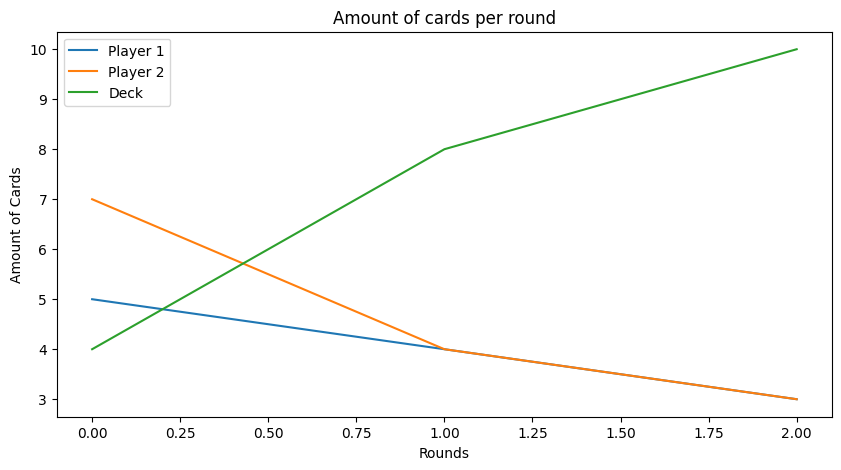

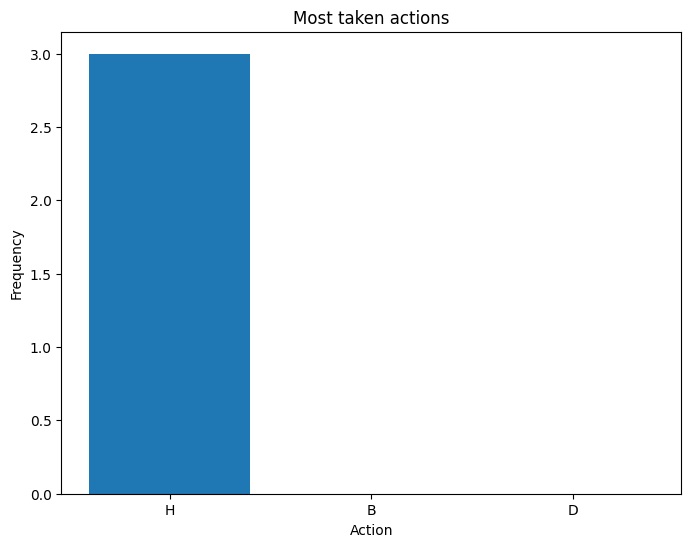

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Graph of quantity of cards
plt.figure(figsize=(10, 5))
plt.plot(player1_cards_history, label='Player 1')
print(player1_cards_history)
plt.plot(player2_cards_history, label='Player 2')
plt.plot(deck_cards_history, label='Deck')
plt.xlabel('Rounds')
plt.ylabel('Amount of Cards')
plt.title('Amount of cards per round')
plt.legend()
plt.show()

# Graph of most taken moves
possible_actions = ['H', 'B', 'D']
unique_moves, move_counts = np.unique(moves_history, return_counts=True)
move_frequencies = {action: 0 for action in possible_actions}

for move, count in zip(unique_moves, move_counts):
    move_frequencies[move] = count

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(move_frequencies.keys(), move_frequencies.values(), align='center', width=0.8)
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Most taken actions')
plt.show()


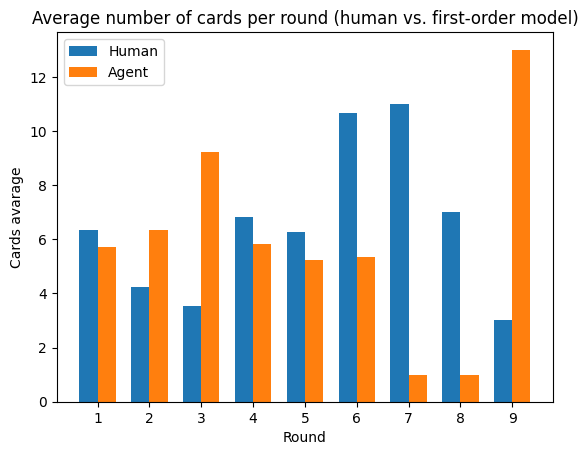

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_avg(data, posicion):
    values = [game[posicion] for game in data if len(game) > posicion]
    return np.mean(values)

avg1 = [calculate_avg(history_player1, i) for i in range(9)]
avg2 = [calculate_avg(history_player2, i) for i in range(9)]

matches = np.arange(1, 10)
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(matches - width/2, avg1, width, label='Human')
bars2 = ax.bar(matches + width/2, avg2, width, label='Agent')

ax.set_xlabel('Round')
ax.set_ylabel('Cards avarage')
ax.set_title('Average number of cards per round (human vs. first-order model)')
ax.set_xticks(matches)
ax.legend()

plt.show()
